In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
#import os

In [2]:
mainpath='d:/Deep Learning 2018/DonorsChoose/'
trainpath='d:/Deep Learning 2018/DonorsChoose/train/'
testpath='d:/Deep Learning 2018/DonorsChoose/test/'

train=pd.read_csv(trainpath+'train.csv')
resources=pd.read_csv(trainpath+'resources.csv')
test=pd.read_csv(testpath+'test.csv')



D:\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## create these features for each proposal:
- total price
- highest single item price

In [3]:
resources['total_price']=resources['price']*resources['quantity'];
                    #if as_index=True by default, these are series; otherwise, it returns a DataFrame
#rg2=resources.groupby(by='id')['total_price'].agg('sum')#same
rg1=resources.groupby(by='id', as_index=False)['total_price'].sum();
rg2=resources.groupby(by='id',as_index=False)['price'].max();
rg2.rename({'price':'highest_single_item_price'},axis='columns',inplace=True);#rename column name
rg12=pd.merge(rg1,rg2,how='inner',on='id');

## Join the tables got from resources.csv & train.csv; resources.csv & test.csv

In [5]:
#print('Projests before 2016-05-17:',np.sum(train1['project_submitted_datetime'] < pd.Timestamp('2016-05-18')))
train1=pd.merge(train,rg12,how='left',on='id')
test1=pd.merge(test,rg12,how='left',on='id')
train1.loc[:,'project_submitted_datetime']=pd.to_datetime(train1.loc[:,'project_submitted_datetime'])
test1.loc[:,'project_submitted_datetime']=pd.to_datetime(test1.loc[:,'project_submitted_datetime'])

In [6]:
print(train1.columns)

Index(['id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'total_price', 'highest_single_item_price'],
      dtype='object')


In [7]:
train1['project_submitted_datetime']=train1['project_submitted_datetime'].dt.date
test1['project_submitted_datetime']=test1['project_submitted_datetime'].dt.date
y_train=train1['project_is_approved']
X_train1=train1.drop(['project_is_approved'],axis=1)
X_test1=test1


## text cleaning

In [8]:
X_train1.loc[X_train1['project_essay_3'].notna(), 'new_essay_policy'] = 0 
X_train1.loc[X_train1['project_essay_3'].isna(), 'new_essay_policy'] = 1 
X_train1.loc[X_train1['project_essay_3'].notna(), 'project_essay_1'] = X_train1.loc[X_train1['project_essay_3'].notna(), 'project_essay_1'] + ' ' + train.loc[X_train1['project_essay_3'].notna(), 'project_essay_2']
X_train1.loc[X_train1['project_essay_3'].notna(), 'project_essay_2'] = X_train1.loc[X_train1['project_essay_3'].notna(), 'project_essay_3'] + ' ' + train.loc[X_train1['project_essay_3'].notna(), 'project_essay_4']




In [9]:
X_test1.loc[X_test1['project_essay_3'].notna(), 'new_essay_policy'] = 0 
X_test1.loc[X_test1['project_essay_3'].isna(), 'new_essay_policy'] = 1 
X_test1.loc[X_test1['project_essay_3'].notna(), 'project_essay_1'] = X_test1.loc[X_test1['project_essay_3'].notna(), 'project_essay_1'] + ' ' + test.loc[X_test1['project_essay_3'].notna(), 'project_essay_2']
X_test1.loc[X_test1['project_essay_3'].notna(), 'project_essay_2'] = X_test1.loc[X_test1['project_essay_3'].notna(), 'project_essay_3'] + ' ' + test.loc[X_test1['project_essay_3'].notna(), 'project_essay_4']



In [10]:
X_train1.drop(['project_essay_3', 'project_essay_4'], axis=1, inplace=True)
X_test1.drop(['project_essay_3', 'project_essay_4'], axis=1, inplace=True)

In [11]:
X_train1['project_essay_1'] = X_train1['project_essay_1'].apply(lambda x: x.replace('\\r', ' ').replace('\\n', ' ').replace('\\', ' ').replace('  ', ' '))
X_train1['project_essay_2'] = X_train1['project_essay_2'].apply(lambda x: x.replace('\\r', ' ').replace('\\n', ' ').replace('\\', ' ').replace('  ', ' '))


In [12]:
X_test1['project_essay_1'] = X_test1['project_essay_1'].apply(lambda x: x.replace('\\r', ' ').replace('\\n', ' ').replace('\\', ' ').replace('  ', ' '))
X_test1['project_essay_2'] = X_test1['project_essay_2'].apply(lambda x: x.replace('\\r', ' ').replace('\\n', ' ').replace('\\', ' ').replace('  ', ' '))


## tokenize lemmatize

In [13]:
from nltk import sent_tokenize, word_tokenize

'''
def count_sent(text):
    if text == "nan" or not text:
        return 0
    sents = sent_tokenize(text)
    return len(sents)
def count_word(text):
    if text=='nan' or not text:
        return 0
    words=word_tokenize(text)
    return len(words)
# these two functions are not used
'''
X_train1['word_length_title'] = X_train1['project_title'].apply(lambda x: len(x.split()))
X_train1['word_project_essay_1'] = X_train1['project_essay_1'].apply(lambda x: len(x.split()))
X_train1['word_project_essay_2'] = X_train1['project_essay_2'].apply(lambda x: len(x.split()))

In [14]:
X_test1['word_length_title'] = X_test1['project_title'].apply(lambda x: len(x.split()))
X_test1['word_project_essay_1'] = X_test1['project_essay_1'].apply(lambda x: len(x.split()))
X_test1['word_project_essay_2'] = X_test1['p ject_essay_2'].apply(lambda x: len(x.split()))

## get sentiment features 

In [15]:
# functions to get polatiy and subjectivity


def get_polarity(text):
    textblob = TextBlob(text)
    pol = textblob.sentiment.polarity
    return round(pol,3)

def get_subjectivity(text):
    textblob = TextBlob(text)
    subj = textblob.sentiment.subjectivity
    return round(subj,3)
X_train1['title_polarity'] = X_train1['project_title'].apply(get_polarity)
X_train1['title_subjectivity'] = X_train1['project_title'].apply(get_subjectivity)
X_train1['essay_1_polarity'] = X_train1['project_essay_1'].apply(get_polarity)
X_train1['essay_1_subjectivity'] = X_train1['project_essay_1'].apply(get_subjectivity)
X_train1['essay_2_polarity'] = X_train1['project_essay_2'].apply(get_polarity)
X_train1['essay_2_subjectivity'] = X_train1['project_essay_2'].apply(get_subjectivity)


In [16]:
X_test1['title_polarity'] = X_test1['project_title'].apply(get_polarity)
X_test1['title_subjectivity'] = X_test1['project_title'].apply(get_subjectivity)
X_test1['essay_1_polarity'] = X_test1['project_essay_1'].apply(get_polarity)
X_test1['essay_1_subjectivity'] = X_test1['project_essay_1'].apply(get_subjectivity)
X_test1['essay_2_polarity'] = X_test1['project_essay_2'].apply(get_polarity)
X_test1['essay_2_subjectivity'] = X_test1['project_essay_2'].apply(get_subjectivity)

In [17]:
X_train1.to_csv("DonorChoose_processed_train.csv")
X_test1.to_csv("DonorChoose_processed_test.csv")

In [18]:
from nltk.corpus import stopwords
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [19]:
import gc
import tqdm
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lifei\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
def tokenize_sentences(sentences, words_dict):
    tokenized_sentences = []
    for sentence in tqdm.tqdm(sentences):
        if hasattr(sentence, "decode"):
            sentence = sentence.decode("utf-8")
        tokens = nltk.tokenize.word_tokenize(sentence)
        result = []
        for word in tokens:
            word = word.lower()
            if word not in words_dict:
                words_dict[word] = len(words_dict)
            word_index = words_dict[word]
            result.append(word_index)
        tokenized_sentences.append(result)
    return tokenized_sentences, words_dict
#embedding
def read_embedding_list(file_path):
    embedding_word_dict = {}
    embedding_list = []
    f = open(file_path, encoding="utf8")
    #f = open(file_path)
    for index, line in enumerate(f):
        if index == 0:
            continue
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            continue
        embedding_list.append(coefs)
        embedding_word_dict[word] = len(embedding_word_dict)
    f.close()
    embedding_list = np.array(embedding_list)
    return embedding_list, embedding_word_dict

def clear_embedding_list(embedding_list, embedding_word_dict, words_dict):
    cleared_embedding_list = []
    cleared_embedding_word_dict = {}

    for word in words_dict:
        if word not in embedding_word_dict:
            continue
        word_id = embedding_word_dict[word]
        row = embedding_list[word_id]
        cleared_embedding_list.append(row)
        cleared_embedding_word_dict[word] = len(cleared_embedding_word_dict)

    return cleared_embedding_list, cleared_embedding_word_dict

def convert_tokens_to_ids(tokenized_sentences, words_list, embedding_word_dict, sentences_length):
    words_train = []

    for sentence in tokenized_sentences:
        current_words = []
        for word_index in sentence:
            word = words_list[word_index]
            word_id = embedding_word_dict.get(word, len(embedding_word_dict) - 2)
            current_words.append(word_id)

        if len(current_words) >= sentences_length:
            current_words = current_words[:sentences_length]
        else:
            current_words += [len(embedding_word_dict) - 1] * (sentences_length - len(current_words))
        words_train.append(current_words)
    return words_train

from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.engine import Layer
from keras.layers import Activation, Add, Bidirectional, Conv1D, Dense, Dropout, Embedding, Flatten
from keras.layers import concatenate, GRU, Input, K, LSTM, MaxPooling1D
from keras.layers import GlobalAveragePooling1D,  GlobalMaxPooling1D, SpatialDropout1D
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing import text, sequence
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks

gru_len = 128
Routings = 5
Num_capsule = 10
Dim_capsule = 16
dropout_p = 0.3
rate_drop_dense = 0.3

def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True)
    scale = K.sqrt(s_squared_norm + K.epsilon())
    return x / scale

# capsule layer

class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, kernel_size=(9, 1), share_weights=True,
                 activation='default', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_size = kernel_size
        self.share_weights = share_weights
        if activation == 'default':
            self.activation = squash
        else:
            self.activation = Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     # shape=self.kernel_size,
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule,
                                            self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        # final u_hat_vecs.shape = [None, num_capsule, input_num_capsule, dim_capsule]

        b = K.zeros_like(u_hat_vecs[:, :, :, 0])  # shape = [None, num_capsule, input_num_capsule]
        for i in range(self.routings):
            b = K.permute_dimensions(b, (0, 2, 1))  # shape = [None, input_num_capsule, num_capsule]
            c = K.softmax(b)
            c = K.permute_dimensions(c, (0, 2, 1))
            b = K.permute_dimensions(b, (0, 2, 1))
            outputs = self.activation(K.batch_dot(c, u_hat_vecs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(outputs, u_hat_vecs, [2, 3])

        return outputs

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

Using TensorFlow backend.


In [21]:
UNKNOWN_WORD = "_UNK_"
END_WORD = "_END_"
NAN_WORD = "_NAN_"
CLASSES = ["project_is_approved"]

In [22]:
X_train1['application_text']=X_train1.apply(lambda row: ' '.join([
    str(row['project_title']),
    str(row['project_essay_1']),
    str(row['project_essay_2']),   
    ]),axis=1)

In [23]:
X_test1['application_text']=X_test1.apply(lambda row: ' '.join([
    str(row['project_title']),
    str(row['project_essay_1']),
    str(row['project_essay_2']),   
    ]),axis=1)

In [24]:
print("Loading data...")
X_train1_data = X_train1
list_sentences_X_train1 = X_train1_data["application_text"].fillna(NAN_WORD).values
X_test1_data = X_test1
list_sentences_X_test1 = X_test1_data["application_text"].fillna(NAN_WORD).values

y_train = y_train.values
print("Done.")

Loading data...
Done.


In [25]:
print("Tokenizing sentences in train set...")
tokenized_sentences_train, words_dict = tokenize_sentences(list_sentences_X_train1, {})
print("Tokenizing sentences in test set...")
tokenized_sentences_test, words_dict = tokenize_sentences(list_sentences_X_test1, words_dict)

Tokenizing sentences in train set...


100%|█████████████████████████████████████████████████████████████████████████| 182080/182080 [13:57<00:00, 217.28it/s]


Tokenizing sentences in test set...


100%|███████████████████████████████████████████████████████████████████████████| 78035/78035 [06:00<00:00, 216.58it/s]


In [26]:
len(words_dict)
# Embedding

embedding_path = "d:/Deep Learning 2018/embeddings/crawl-300d-2M.vec"

#embedding_path = "F:/Deep Learning 2018/DonorsChoose/embeddings_small.vec"

words_dict[UNKNOWN_WORD] = len(words_dict)
print("Loading embeddings...")
embedding_list, embedding_word_dict = read_embedding_list(embedding_path)
embedding_size = len(embedding_list[0])
print("Done")

Loading embeddings...
Done


In [27]:
batch_size = 256
recurrent_units = 64
dropout_rate = 0.3 
dense_size = 32
sentences_length = 320
fold_count = 5

In [28]:
print("Preparing data...")
embedding_list, embedding_word_dict = clear_embedding_list(embedding_list, embedding_word_dict, words_dict)

embedding_word_dict[UNKNOWN_WORD] = len(embedding_word_dict)
embedding_list.append([0.] * embedding_size)
embedding_word_dict[END_WORD] = len(embedding_word_dict)
embedding_list.append([-1.] * embedding_size)

embedding_matrix = np.array(embedding_list)

id_to_word = dict((id, word) for word, id in words_dict.items())
train_list_of_token_ids = convert_tokens_to_ids(
    tokenized_sentences_train,
    id_to_word,
    embedding_word_dict,
    sentences_length)
test_list_of_token_ids = convert_tokens_to_ids(
    tokenized_sentences_test,
    id_to_word,
    embedding_word_dict,
    sentences_length)
X_train_text = np.array(train_list_of_token_ids)
X_test_text = np.array(test_list_of_token_ids)
print("Done")

Preparing data...
Done


## save intermediate model 

In [29]:
print(len(words_dict))

import pickle


def save_obj(obj, fname):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)
    
save_obj(X_train_text,'X_train_text.pkl')
X_train1.to_csv('DonorChoose_processed_train_combined_text.csv')


142444


In [30]:
save_obj(X_test_text,'X_test_text.pkl')
X_test1.to_csv('DonorChoose_processed_test_combined_text.csv')

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

class add_features(BaseEstimator, TransformerMixin):
    """Takes in dataframe, extracts road name column, outputs average word length"""

    def __init__(self):
        pass #self.vars = vars  # e.g. pass in a column name to extract

    def convert_log(self, previous_proposals):#passed in is a Series?no datapoint
        #return np.mean([len(word) for word in name.split()])
        result=np.log(1+float(previous_proposals))
        #print(result)
        return result

    def transform(self, df, y=None):
        """The workhorse of this feature extractor"""
        """features about reject pressure. project viewers need to reject certain percentage
        of proposals due to limited resources. 
        This is probably a better way to use datetime info"""
        pd.options.mode.chained_assignment = None#ignore SettingWithCopyWarning because it's false positive, everything I do here is on a copy and I return a copy. if I change the names of df to df1,df2 etc, the warning should be gone.

        df.loc[:,'reject_pressure_by_funds']=df.groupby('project_submitted_datetime')['total_price'].transform(lambda x: x.sum())
        df.loc[:,'reject_pressure_by_projects']=df.groupby('project_submitted_datetime')['total_price'].transform(lambda x: x.count())
        df.loc[:,'log_previously_posted_projects']=df['teacher_number_of_previously_posted_projects'].apply(self.convert_log)
        #create DataFrames that contain categorical information
        prefix = pd.get_dummies(df['teacher_prefix'],drop_first=False)
        state=pd.get_dummies(df['school_state'],drop_first=False)
        grade= pd.get_dummies(df['project_grade_category'],drop_first=False)
        category= pd.get_dummies(df['project_subject_categories'],drop_first=False)
        #sub_category=pd.get_dummies(df['project_subject_subcategories'],drop_first=False)
        missing_cols_main=set(complete_prefix+complete_state+complete_grade+complete_category)-(set(list(prefix))|set(list(state))|set(list(grade))|set(list(category)))
        #missing_cols_extra=set(complete_sub_category)-set(list(sub_category))
        #set(complete_category)&set(complete_sub_category) not empty
        #print (missing_cols_main)
        #print (missing_cols_extra)
        df=pd.concat([df,prefix],axis=1)
        df=pd.concat([df,state],axis=1)
        df=pd.concat([df,grade],axis=1)
        df=pd.concat([df,category],axis=1)
        #df=pd.concat([df,sub_category],axis=1)
        for c1 in missing_cols_main:
            df.loc[:,c1] = 0
        #for c2 in missing_cols_extra:
        #    df.loc[:,c2] = 0
        #del prefix,state,grade,category#,sub_category
        #del missing_cols_main
        #del missing_cols_extra

        to_be_dropped_sure=['id',
         'teacher_id',
         'teacher_prefix',
         'school_state',
         'project_submitted_datetime',
         'project_grade_category',
         'project_subject_categories',
         'project_subject_subcategories',
         'project_title',
         'project_essay_1',
         'project_essay_2',
         'project_resource_summary',
         'teacher_number_of_previously_posted_projects','application_text']
        to_be_dropped=to_be_dropped_sure#+complete_prefix+complete_state+complete_grade+complete_category#+complete_sub_category
        #print(df.drop(to_be_dropped,axis=1).head(1))
        df.drop(to_be_dropped,axis=1,inplace=True)
        return df

    def fit(self, df, y=None,**fit_params):
        """Returns `self` unless something different happens in train and test"""
        return self


In [32]:
complete_prefix=list(X_train1['teacher_prefix'].dropna(axis=0, how='any').unique())
complete_state=list(X_train1['school_state'].unique())
complete_grade=list(X_train1['project_grade_category'].unique())
complete_category=list(X_train1['project_subject_categories'].unique())#51 categories
#complete_sub_category=list(X_train1['project_subject_subcategories'].unique())#407 sub-categories

X_train_nontextpart=StandardScaler().fit_transform(add_features().transform(X_train1))

In [33]:
complete_prefix=list(X_test1['teacher_prefix'].dropna(axis=0, how='any').unique())
complete_state=list(X_test1['school_state'].unique())
complete_grade=list(X_test1['project_grade_category'].unique())
complete_category=list(X_test1['project_subject_categories'].unique())#51 categories
#complete_sub_category=list(X_test1['project_subject_subcategories'].unique())#407 sub-categories

X_test_nontextpart=StandardScaler().fit_transform(add_features().transform(X_test1))

In [34]:
print(X_train_nontextpart.shape)
print(X_train_text.shape)
#print(X_test_nontextpart.shape)
#X_train_formodel=np.concatenate((X_train_nontextpart,X_train_text),axis=1)
#X_test_formodel=np.concatenate((X_test_nontextpart,X_test_text),axis=1)
#print(X_train_formodel.shape)

(182080, 126)
(182080, 320)


In [35]:
def get_model(embedding_matrix, sequence_length, dropout_rate, recurrent_units, dense_size):
    
    nontext = Input(shape=[X_train_nontextpart.shape[1]], name="nontext")
    nontext1 = Dense(64, activation='relu')(nontext)
    nontext1 = Dense(128, activation='relu')(nontext1) 
    
    textpart = Input(shape=(sequence_length,),name="text")
    
    embed_layer = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                                weights=[embedding_matrix], trainable=False)(textpart)
    embed_layer = SpatialDropout1D(rate_drop_dense)(embed_layer)

    x_text = Bidirectional(
        GRU(gru_len, activation='relu', dropout=dropout_p, recurrent_dropout=dropout_p, return_sequences=True))(
        embed_layer)
    capsule = Capsule(num_capsule=Num_capsule, dim_capsule=Dim_capsule, routings=Routings,
                      share_weights=True)(x_text)
    capsule = Flatten()(capsule)
    capsule = Dropout(dropout_p)(capsule)
    
    X = concatenate([
        nontext1,
        capsule,
    ])    
    
    output = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=[nontext, textpart], outputs=output)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    return model

model2=get_model(
    embedding_matrix,
    sentences_length,
    dropout_rate,
    recurrent_units,
    dense_size)

model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, 320)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 320, 300)     23672400    text[0][0]                       
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 320, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 320, 256)     329472      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
nontext (I

In [36]:
history_new=model2.fit([X_train_nontextpart, X_train_text], y_train, epochs=6, batch_size=256, validation_split=0.2, verbose=1)

Train on 145664 samples, validate on 36416 samples
Epoch 1/6
 51712/145664 [=========>....................] - ETA: 1:40:23 - loss: 0.4522 - acc: 0.89 - ETA: 59:40 - loss: 0.4533 - acc: 0.8711 - ETA: 46:15 - loss: 0.4560 - acc: 0.86 - ETA: 39:12 - loss: 0.4581 - acc: 0.86 - ETA: 34:58 - loss: 0.4534 - acc: 0.86 - ETA: 32:13 - loss: 0.4484 - acc: 0.85 - ETA: 30:17 - loss: 0.4494 - acc: 0.85 - ETA: 28:46 - loss: 0.4456 - acc: 0.85 - ETA: 27:43 - loss: 0.4437 - acc: 0.85 - ETA: 26:47 - loss: 0.4397 - acc: 0.85 - ETA: 25:59 - loss: 0.4382 - acc: 0.85 - ETA: 25:16 - loss: 0.4378 - acc: 0.85 - ETA: 24:44 - loss: 0.4430 - acc: 0.85 - ETA: 24:19 - loss: 0.4406 - acc: 0.85 - ETA: 23:57 - loss: 0.4441 - acc: 0.85 - ETA: 23:34 - loss: 0.4450 - acc: 0.85 - ETA: 23:11 - loss: 0.4411 - acc: 0.85 - ETA: 22:55 - loss: 0.4407 - acc: 0.85 - ETA: 22:39 - loss: 0.4389 - acc: 0.85 - ETA: 22:23 - loss: 0.4362 - acc: 0.85 - ETA: 22:07 - loss: 0.4344 - acc: 0.85 - ETA: 21:56 - loss: 0.4324 - acc: 0.85 - ETA: 2

 52224/145664 [=========>....................] - ETA: 18:32 - loss: 0.4522 - acc: 0.80 - ETA: 18:48 - loss: 0.4121 - acc: 0.83 - ETA: 18:47 - loss: 0.4025 - acc: 0.84 - ETA: 18:50 - loss: 0.3920 - acc: 0.84 - ETA: 18:40 - loss: 0.3912 - acc: 0.84 - ETA: 18:42 - loss: 0.3916 - acc: 0.84 - ETA: 18:40 - loss: 0.3863 - acc: 0.84 - ETA: 18:40 - loss: 0.3842 - acc: 0.84 - ETA: 18:36 - loss: 0.3836 - acc: 0.84 - ETA: 18:37 - loss: 0.3856 - acc: 0.84 - ETA: 18:38 - loss: 0.3817 - acc: 0.84 - ETA: 18:35 - loss: 0.3766 - acc: 0.85 - ETA: 18:30 - loss: 0.3811 - acc: 0.84 - ETA: 18:30 - loss: 0.3796 - acc: 0.84 - ETA: 18:29 - loss: 0.3744 - acc: 0.85 - ETA: 18:27 - loss: 0.3732 - acc: 0.85 - ETA: 18:22 - loss: 0.3772 - acc: 0.84 - ETA: 18:22 - loss: 0.3770 - acc: 0.84 - ETA: 18:20 - loss: 0.3757 - acc: 0.84 - ETA: 18:19 - loss: 0.3749 - acc: 0.84 - ETA: 18:18 - loss: 0.3730 - acc: 0.85 - ETA: 18:17 - loss: 0.3701 - acc: 0.85 - ETA: 18:17 - loss: 0.3709 - acc: 0.85 - ETA: 18:17 - loss: 0.3704 - acc

104448/145664 [====================>.........] - ETA: 12:13 - loss: 0.3787 - acc: 0.85 - ETA: 12:11 - loss: 0.3788 - acc: 0.85 - ETA: 12:08 - loss: 0.3789 - acc: 0.85 - ETA: 12:07 - loss: 0.3789 - acc: 0.85 - ETA: 12:04 - loss: 0.3784 - acc: 0.85 - ETA: 12:02 - loss: 0.3783 - acc: 0.85 - ETA: 12:00 - loss: 0.3781 - acc: 0.85 - ETA: 11:58 - loss: 0.3784 - acc: 0.85 - ETA: 11:56 - loss: 0.3784 - acc: 0.85 - ETA: 11:54 - loss: 0.3782 - acc: 0.85 - ETA: 11:52 - loss: 0.3777 - acc: 0.85 - ETA: 11:50 - loss: 0.3777 - acc: 0.85 - ETA: 11:48 - loss: 0.3777 - acc: 0.85 - ETA: 11:46 - loss: 0.3775 - acc: 0.85 - ETA: 11:44 - loss: 0.3775 - acc: 0.85 - ETA: 11:42 - loss: 0.3776 - acc: 0.85 - ETA: 11:40 - loss: 0.3776 - acc: 0.85 - ETA: 11:38 - loss: 0.3777 - acc: 0.85 - ETA: 11:36 - loss: 0.3775 - acc: 0.85 - ETA: 11:34 - loss: 0.3774 - acc: 0.85 - ETA: 11:32 - loss: 0.3773 - acc: 0.85 - ETA: 11:30 - loss: 0.3771 - acc: 0.85 - ETA: 11:28 - loss: 0.3770 - acc: 0.85 - ETA: 11:26 - loss: 0.3771 - acc

145664/145664 [==============================] - ETA: 5:19 - loss: 0.3743 - acc: 0.852 - ETA: 5:17 - loss: 0.3743 - acc: 0.852 - ETA: 5:15 - loss: 0.3743 - acc: 0.852 - ETA: 5:13 - loss: 0.3742 - acc: 0.852 - ETA: 5:11 - loss: 0.3742 - acc: 0.852 - ETA: 5:09 - loss: 0.3741 - acc: 0.852 - ETA: 5:07 - loss: 0.3742 - acc: 0.852 - ETA: 5:05 - loss: 0.3743 - acc: 0.852 - ETA: 5:03 - loss: 0.3742 - acc: 0.852 - ETA: 5:01 - loss: 0.3741 - acc: 0.852 - ETA: 4:59 - loss: 0.3740 - acc: 0.852 - ETA: 4:57 - loss: 0.3741 - acc: 0.852 - ETA: 4:55 - loss: 0.3740 - acc: 0.852 - ETA: 4:53 - loss: 0.3740 - acc: 0.852 - ETA: 4:51 - loss: 0.3740 - acc: 0.852 - ETA: 4:49 - loss: 0.3741 - acc: 0.852 - ETA: 4:47 - loss: 0.3743 - acc: 0.852 - ETA: 4:45 - loss: 0.3743 - acc: 0.852 - ETA: 4:43 - loss: 0.3741 - acc: 0.852 - ETA: 4:41 - loss: 0.3742 - acc: 0.852 - ETA: 4:39 - loss: 0.3741 - acc: 0.852 - ETA: 4:37 - loss: 0.3742 - acc: 0.852 - ETA: 4:35 - loss: 0.3741 - acc: 0.852 - ETA: 4:33 - loss: 0.3741 - acc:

 52224/145664 [=========>....................] - ETA: 18:54 - loss: 0.3810 - acc: 0.84 - ETA: 18:35 - loss: 0.3824 - acc: 0.84 - ETA: 18:34 - loss: 0.3770 - acc: 0.84 - ETA: 18:35 - loss: 0.3856 - acc: 0.84 - ETA: 18:35 - loss: 0.3822 - acc: 0.84 - ETA: 18:24 - loss: 0.3694 - acc: 0.85 - ETA: 18:25 - loss: 0.3698 - acc: 0.85 - ETA: 18:25 - loss: 0.3688 - acc: 0.85 - ETA: 18:18 - loss: 0.3766 - acc: 0.85 - ETA: 18:15 - loss: 0.3758 - acc: 0.85 - ETA: 18:16 - loss: 0.3692 - acc: 0.85 - ETA: 18:15 - loss: 0.3696 - acc: 0.85 - ETA: 18:15 - loss: 0.3669 - acc: 0.85 - ETA: 18:14 - loss: 0.3669 - acc: 0.85 - ETA: 18:12 - loss: 0.3695 - acc: 0.85 - ETA: 18:07 - loss: 0.3693 - acc: 0.85 - ETA: 18:05 - loss: 0.3673 - acc: 0.85 - ETA: 18:05 - loss: 0.3675 - acc: 0.85 - ETA: 18:05 - loss: 0.3673 - acc: 0.85 - ETA: 18:04 - loss: 0.3654 - acc: 0.85 - ETA: 18:02 - loss: 0.3638 - acc: 0.85 - ETA: 18:02 - loss: 0.3639 - acc: 0.85 - ETA: 17:58 - loss: 0.3644 - acc: 0.85 - ETA: 17:55 - loss: 0.3657 - acc

 52224/145664 [=========>....................] - ETA: 19:20 - loss: 0.3725 - acc: 0.86 - ETA: 19:19 - loss: 0.3402 - acc: 0.86 - ETA: 19:14 - loss: 0.3580 - acc: 0.85 - ETA: 19:05 - loss: 0.3544 - acc: 0.85 - ETA: 18:53 - loss: 0.3562 - acc: 0.86 - ETA: 18:49 - loss: 0.3679 - acc: 0.85 - ETA: 18:50 - loss: 0.3575 - acc: 0.86 - ETA: 18:50 - loss: 0.3506 - acc: 0.86 - ETA: 18:38 - loss: 0.3475 - acc: 0.86 - ETA: 18:36 - loss: 0.3413 - acc: 0.86 - ETA: 18:32 - loss: 0.3459 - acc: 0.86 - ETA: 18:27 - loss: 0.3473 - acc: 0.86 - ETA: 18:26 - loss: 0.3514 - acc: 0.86 - ETA: 18:24 - loss: 0.3530 - acc: 0.86 - ETA: 18:22 - loss: 0.3581 - acc: 0.85 - ETA: 18:19 - loss: 0.3572 - acc: 0.85 - ETA: 18:18 - loss: 0.3552 - acc: 0.86 - ETA: 18:22 - loss: 0.3568 - acc: 0.85 - ETA: 18:19 - loss: 0.3571 - acc: 0.85 - ETA: 18:15 - loss: 0.3545 - acc: 0.85 - ETA: 18:13 - loss: 0.3549 - acc: 0.85 - ETA: 18:11 - loss: 0.3581 - acc: 0.85 - ETA: 18:09 - loss: 0.3592 - acc: 0.85 - ETA: 18:03 - loss: 0.3604 - acc

145664/145664 [==============================] - ETA: 25:25 - loss: 0.3589 - acc: 0.85 - ETA: 25:12 - loss: 0.3590 - acc: 0.85 - ETA: 24:59 - loss: 0.3589 - acc: 0.85 - ETA: 24:46 - loss: 0.3589 - acc: 0.85 - ETA: 24:34 - loss: 0.3589 - acc: 0.85 - ETA: 24:21 - loss: 0.3589 - acc: 0.85 - ETA: 24:09 - loss: 0.3588 - acc: 0.85 - ETA: 23:56 - loss: 0.3588 - acc: 0.85 - ETA: 23:44 - loss: 0.3587 - acc: 0.85 - ETA: 23:32 - loss: 0.3587 - acc: 0.85 - ETA: 23:19 - loss: 0.3587 - acc: 0.85 - ETA: 23:07 - loss: 0.3586 - acc: 0.85 - ETA: 22:55 - loss: 0.3587 - acc: 0.85 - ETA: 22:43 - loss: 0.3586 - acc: 0.85 - ETA: 22:31 - loss: 0.3588 - acc: 0.85 - ETA: 22:19 - loss: 0.3588 - acc: 0.85 - ETA: 22:07 - loss: 0.3587 - acc: 0.85 - ETA: 21:55 - loss: 0.3588 - acc: 0.85 - ETA: 21:43 - loss: 0.3587 - acc: 0.85 - ETA: 21:31 - loss: 0.3587 - acc: 0.85 - ETA: 21:20 - loss: 0.3586 - acc: 0.85 - ETA: 21:08 - loss: 0.3586 - acc: 0.85 - ETA: 20:56 - loss: 0.3585 - acc: 0.85 - ETA: 20:45 - loss: 0.3584 - acc

 52224/145664 [=========>....................] - ETA: 14:09 - loss: 0.3163 - acc: 0.86 - ETA: 11:57 - loss: 0.3317 - acc: 0.85 - ETA: 11:12 - loss: 0.3535 - acc: 0.84 - ETA: 10:49 - loss: 0.3562 - acc: 0.84 - ETA: 10:30 - loss: 0.3535 - acc: 0.84 - ETA: 10:14 - loss: 0.3580 - acc: 0.85 - ETA: 10:09 - loss: 0.3488 - acc: 0.85 - ETA: 10:06 - loss: 0.3487 - acc: 0.85 - ETA: 10:01 - loss: 0.3484 - acc: 0.85 - ETA: 9:58 - loss: 0.3537 - acc: 0.8562 - ETA: 9:51 - loss: 0.3496 - acc: 0.859 - ETA: 9:51 - loss: 0.3451 - acc: 0.862 - ETA: 9:48 - loss: 0.3441 - acc: 0.862 - ETA: 9:47 - loss: 0.3418 - acc: 0.863 - ETA: 9:45 - loss: 0.3447 - acc: 0.863 - ETA: 9:43 - loss: 0.3464 - acc: 0.862 - ETA: 9:39 - loss: 0.3487 - acc: 0.860 - ETA: 9:38 - loss: 0.3489 - acc: 0.859 - ETA: 9:35 - loss: 0.3526 - acc: 0.857 - ETA: 9:34 - loss: 0.3528 - acc: 0.858 - ETA: 9:33 - loss: 0.3518 - acc: 0.859 - ETA: 9:32 - loss: 0.3511 - acc: 0.860 - ETA: 9:28 - loss: 0.3523 - acc: 0.860 - ETA: 9:27 - loss: 0.3534 - acc

 52224/145664 [=========>....................] - ETA: 9:51 - loss: 0.3802 - acc: 0.832 - ETA: 9:43 - loss: 0.3571 - acc: 0.857 - ETA: 9:31 - loss: 0.3618 - acc: 0.856 - ETA: 9:33 - loss: 0.3660 - acc: 0.854 - ETA: 9:28 - loss: 0.3519 - acc: 0.859 - ETA: 9:29 - loss: 0.3497 - acc: 0.859 - ETA: 9:26 - loss: 0.3484 - acc: 0.861 - ETA: 9:26 - loss: 0.3539 - acc: 0.856 - ETA: 9:25 - loss: 0.3476 - acc: 0.859 - ETA: 9:27 - loss: 0.3552 - acc: 0.857 - ETA: 9:28 - loss: 0.3536 - acc: 0.859 - ETA: 9:28 - loss: 0.3502 - acc: 0.860 - ETA: 9:24 - loss: 0.3518 - acc: 0.859 - ETA: 9:22 - loss: 0.3528 - acc: 0.859 - ETA: 9:22 - loss: 0.3528 - acc: 0.857 - ETA: 9:22 - loss: 0.3562 - acc: 0.856 - ETA: 9:20 - loss: 0.3556 - acc: 0.856 - ETA: 9:19 - loss: 0.3506 - acc: 0.858 - ETA: 9:18 - loss: 0.3484 - acc: 0.859 - ETA: 9:18 - loss: 0.3505 - acc: 0.858 - ETA: 9:18 - loss: 0.3553 - acc: 0.856 - ETA: 9:18 - loss: 0.3583 - acc: 0.854 - ETA: 9:17 - loss: 0.3559 - acc: 0.855 - ETA: 9:15 - loss: 0.3538 - acc:

145664/145664 [==============================] - ETA: 2:43 - loss: 0.3520 - acc: 0.859 - ETA: 2:42 - loss: 0.3519 - acc: 0.859 - ETA: 2:41 - loss: 0.3520 - acc: 0.859 - ETA: 2:40 - loss: 0.3520 - acc: 0.859 - ETA: 2:39 - loss: 0.3520 - acc: 0.859 - ETA: 2:38 - loss: 0.3521 - acc: 0.859 - ETA: 2:37 - loss: 0.3521 - acc: 0.859 - ETA: 2:36 - loss: 0.3521 - acc: 0.859 - ETA: 2:35 - loss: 0.3520 - acc: 0.859 - ETA: 2:33 - loss: 0.3519 - acc: 0.859 - ETA: 2:32 - loss: 0.3520 - acc: 0.859 - ETA: 2:31 - loss: 0.3521 - acc: 0.859 - ETA: 2:30 - loss: 0.3521 - acc: 0.859 - ETA: 2:29 - loss: 0.3522 - acc: 0.859 - ETA: 2:28 - loss: 0.3522 - acc: 0.859 - ETA: 2:27 - loss: 0.3521 - acc: 0.859 - ETA: 2:26 - loss: 0.3521 - acc: 0.859 - ETA: 2:25 - loss: 0.3520 - acc: 0.859 - ETA: 2:24 - loss: 0.3522 - acc: 0.859 - ETA: 2:23 - loss: 0.3521 - acc: 0.859 - ETA: 2:22 - loss: 0.3520 - acc: 0.859 - ETA: 2:21 - loss: 0.3520 - acc: 0.859 - ETA: 2:20 - loss: 0.3520 - acc: 0.859 - ETA: 2:19 - loss: 0.3519 - acc:

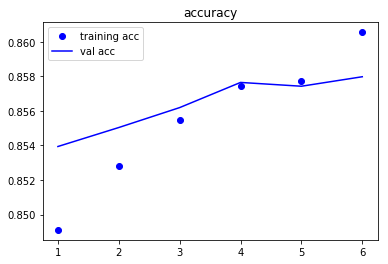

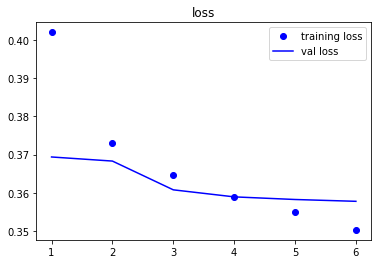

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history_new.history['acc']
val_acc = history_new.history['val_acc']
loss = history_new.history['loss']
val_loss = history_new.history['val_loss']

epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='training acc')
plt.plot(epochs,val_acc,'b',label='val acc')

plt.title('accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label='training loss')
plt.plot(epochs,val_loss,'b',label='val loss')

plt.title('loss')
plt.legend()

plt.show()
#8 epochs is best

In [41]:
model2.save('model_new_6epochs.h5')

In [42]:
#from keras.models import load_model
#import h5py
#model1 = load_model('model1.h5')



pred = model2.predict([X_test_nontextpart, X_test_text], batch_size=256, verbose=1)
submission = pd.DataFrame({
    "id": test["id"],
    "project_is_approved": pred.reshape(-1),
})
submission.to_csv('fiddle_6epoch_4-24.csv', index=False)

78035/78035 [==============================] - ETA: 5: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA

# one more epoch

In [43]:
pred_val = model2.predict([X_train_nontextpart[-36416:],X_train_text[-36416:]], batch_size=256, verbose=1)

z=y_train[-36416:].reshape(-1,1)
from sklearn.metrics import roc_auc_score
roc_auc_score(z, pred_val, sample_weight=None)



36416/36416 [==============================] - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 58s - ETA: 56 - ETA: 56 - ETA: 55 - ETA: 54 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 17 - ET

0.7724301297272691

In [44]:
pred_val = model2.predict([X_train_nontextpart,X_train_text], batch_size=256, verbose=1)

z=y_train.reshape(-1,1)

roc_auc_score(z, pred_val, sample_weight=None)

182080/182080 [==============================] - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - E

0.80095623597973953